# <b>DiaCheck</b>

Dataset: https://www.kaggle.com/datasets/717451f4573e9c3d8963e626808ade67a89fbd2ee660be008c1aba16b2a2345a

## <b>Menyaipkan semua library yang dibutuhkan</b>

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib

## <b>Main Functions</b>

In [230]:
def label_encode(df, columns):
    """
    Fungsi untuk melakukan label encoding pada kolom yang dipilih dalam DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame yang akan di-encode.
        columns (list): Daftar kolom yang akan di-label encode.
        
    Returns:
        pd.DataFrame: DataFrame dengan kolom yang sudah di-label encode.
    """
    label_encoder = LabelEncoder()
    
    for column in columns:
        df[column] = label_encoder.fit_transform(df[column])
    
    return df

In [ ]:
def plot_data_corr(df, columns, target, labels=("Diabetes", "Diabetes"), colors=("blue", "red")):
    """
    Membuat plot korelasi data untuk setiap kolom dalam data berdasarkan nilai target.

    Parameters:
        data (DataFrame): Dataset yang akan digunakan.
        columns (list): List kolom yang ingin dianalisis.
        target (str): Nama kolom target (label).
        labels (tuple): Label untuk setiap nilai target (default=("Diabetes", "Diabetes")).
        colors (tuple): Warna untuk setiap nilai target (default=("blue", "red")).

    Returns:
        None: Fungsi ini tidak mengembalikan nilai, tetapi menampilkan plot distribusi Kernel Density Estimation (KDE) untuk setiap kolom yang dianalisis.
    """
    for column in columns:
        plt.figure(figsize=(6, 3))
        sns.kdeplot(df[column][df[target] == 0], color=colors[0], fill=True, label=f"{target} = {labels[0]}")
        sns.kdeplot(df[column][df[target] == 1], color=colors[1], fill=True, label=f"{target} = {labels[1]}")
        plt.title(f'{column} by {target}')
        plt.legend()
        plt.show()

In [232]:
def plot_loss_acc(history):
    """
    Fungsi untuk memvisualisasikan loss dan akurasi model selama proses pelatihan dan validasi.
    
    Parameters:
        history (keras.callbacks.History): Objek yang menyimpan riwayat pelatihan model, termasuk loss dan akurasi untuk data pelatihan dan validasi.
        
    Returns:
        None: Fungsi ini tidak mengembalikan nilai, tetapi menampilkan grafik loss dan akurasi.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot training dan validation loss
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    ax[0].set_title('Loss')

    # Plot training dan validation accuracy
    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    ax[1].set_title('Accuracy')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrices(cm1, cm2, classes, titles=['Training', 'Testing']):
    """
    Fungsi untuk memvisualisasikan dua confusion matrix untuk data pelatihan dan pengujian.

    Parameters:
        cm1 (numpy): Confusion matrix untuk data pelatihan.
        cm2 (numpy): Confusion matrix untuk data pengujian.
        classes (list): Daftar nama kelas yang digunakan untuk menamai label pada matriks.
        titles (list): Daftar judul untuk kedua plot confusion matrix, default adalah ['Training', 'Testing'].

    Returns:
        None: Fungsi ini tidak mengembalikan nilai, tetapi menampilkan dua grafik confusion matrix yang terpisah.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Plot untuk confusion matrix pertama
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[0], cbar=False)
    ax[0].set_title(f'Confusion Matrix - {titles[0]}')
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_xticks(np.arange(len(classes)))
    ax[0].set_yticks(np.arange(len(classes)))

    # Plot untuk confusion matrix kedua
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax[1], cbar=False)
    ax[1].set_title(f'Confusion Matrix - {titles[1]}')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_xticks(np.arange(len(classes)))
    ax[1].set_yticks(np.arange(len(classes)))

    plt.tight_layout()
    plt.show()

## <b>Data Wrangling</b>

### <b>Gathering Data</b>

In [234]:
df = pd.read_csv('data/diabetes.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


### <b>Assessing Data</b>

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [236]:
df.shape

(100000, 9)

In [237]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


Memeriksa jumlah value tiap kolom

In [238]:
for column in df.columns:
    print(f"{column}: {df[column].value_counts()}\n")

gender: gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

age: age
80.00    5621
51.00    1619
47.00    1574
48.00    1568
53.00    1542
         ... 
0.48       83
1.00       83
0.40       66
0.16       59
0.08       36
Name: count, Length: 102, dtype: int64

hypertension: hypertension
0    92515
1     7485
Name: count, dtype: int64

heart_disease: heart_disease
0    96058
1     3942
Name: count, dtype: int64

smoking_history: smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

bmi: bmi
27.32    25495
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
58.23        1
48.18        1
55.57        1
57.07        1
60.52        1
Name: count, Length: 4247, dtype: int64

HbA1c_level: HbA1c_level
6.6    8540
5.7    8413
6.5    8362
5.8    8321
6.0    8295
6.2    8269
6.1    8048
3.5    7662
4.8    7597
4.5    7585
4.0    

Memeriksa missing values

In [239]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Memeriksa duplikasi data

In [240]:
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  3854


Oke, sampai tahap ini, kita telah berhasil mengidentifikasi berbagai masalah pada data yang telah kita kumpulkan. Berikut merupakan rangkumannya.<br>
| Type Data                                                                                                    | Missing Value | Duplicate Data | Inaccurate Value |
|--------------------------------------------------------------------------------------------------------------|---------------|----------------|------------------|
| Terdapat kesalahan type data untuk kolom gender. | -            | Terdapat 3854 duplikasi data              | Terdapat 18 value Other pada kolom gender                |

### <b>Cleaning Data</b>

Pada tahap ini, kita akan membersihkan berbagai masalah yang telah teridentifikasi dalam proses assessing data.
- Menghapus duplikasi data.
- Mengubah value Other pada kolom <b><i>gender</i></b> menjadi value yang paling banyak, yaitu Female.
- Mengganti value pada kolom <b><i>gender</i></b> menjadi integer menggunakan <b><i>Label Encoding</i></b>.<br>
  Note:<br>
  - Female = 0
  - Male = 1<br>
- Menghapus kolom <b><i>smoking_history</i></b> karena banyak data yang No Info.

##### 1. Menghapus duplikasi data

In [241]:
df.drop_duplicates(inplace=True)
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


##### 2. Mengubah value

In [242]:
gender = df['gender'].value_counts()
print(gender)

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64


In [243]:
df['gender'] = df['gender'].replace({
    'Other': 'Female'
})

##### 3. Label encoding

In [244]:
df = label_encode(df, ['gender'])

##### 4. Menghapus kolom yang kurang relevan

In [246]:
df.drop('smoking_history', axis=1, inplace=True)

In [247]:
df.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,25.19,6.6,140,0
1,0,54.0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,27.32,5.7,158,0
3,0,36.0,0,0,23.45,5.0,155,0
4,1,76.0,1,1,20.14,4.8,155,0


In [248]:
df.shape

(96146, 8)

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  int32  
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   bmi                  96146 non-null  float64
 5   HbA1c_level          96146 non-null  float64
 6   blood_glucose_level  96146 non-null  int64  
 7   diabetes             96146 non-null  int64  
dtypes: float64(3), int32(1), int64(4)
memory usage: 6.2 MB


Save data yang sudah dicleaning

In [250]:
df.to_csv("data/diabetes_clean.csv", index=False)

## <b>Virtualization Data</b>

### <b>Korelasi Data</b>

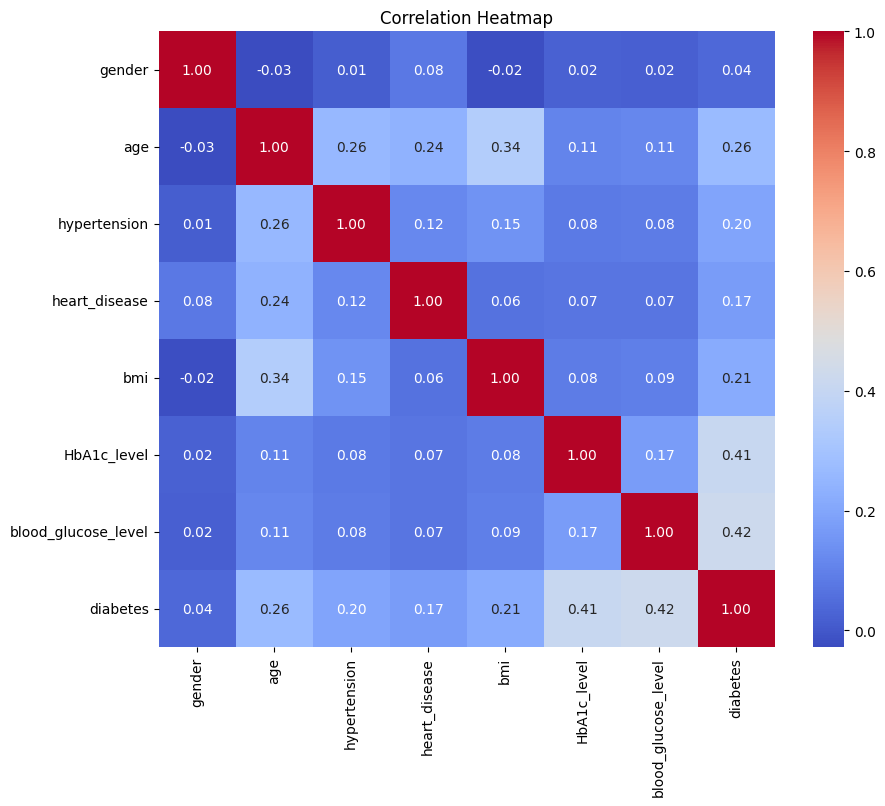

In [251]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

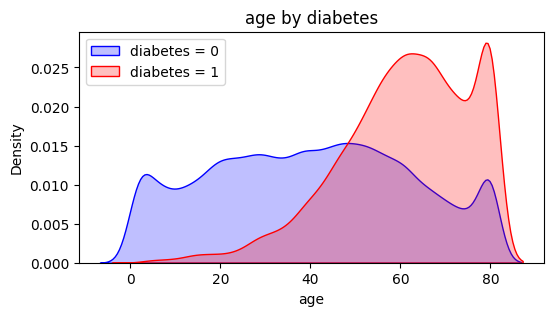

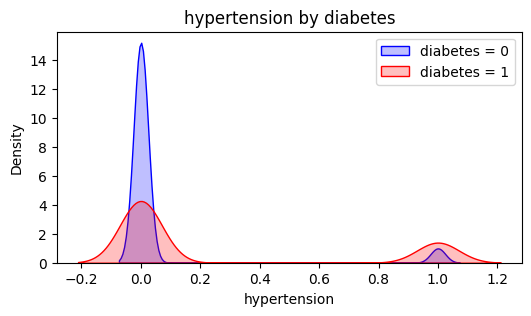

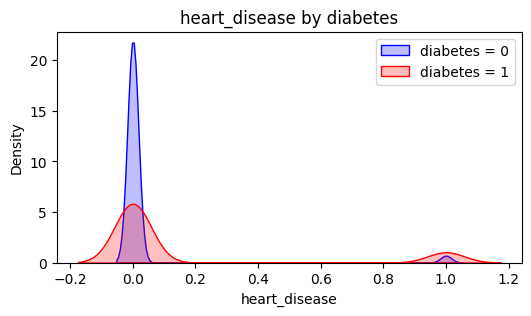

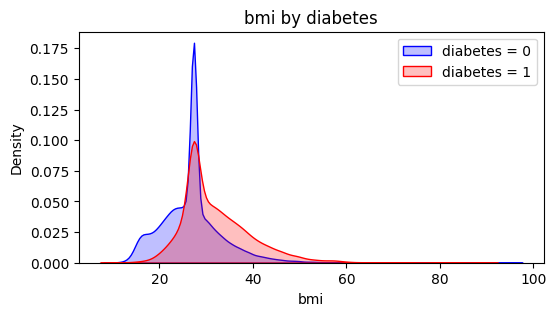

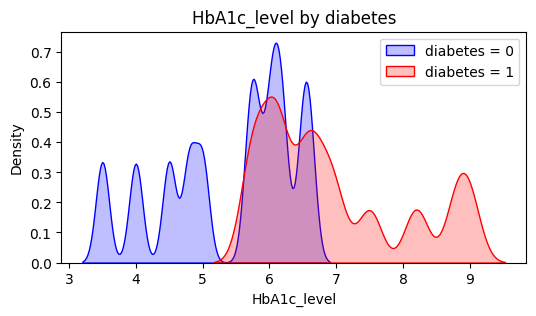

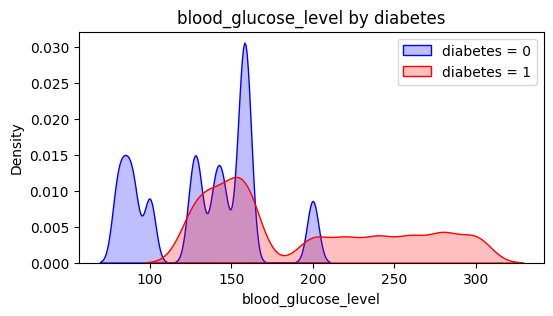

In [252]:
columns = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
plot_data_corr(df, columns, target='diabetes', labels=("0", "1"))

## <b>Deep Neural Network (DNN)</b>

In [253]:
df = pd.read_csv('data/diabetes_clean.csv')

In [254]:
X = df.drop('diabetes', axis=1)  # Fitur
y = df['diabetes']               # Target

### <b>Split Data</b>

In [255]:
# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### <b>Resampling</b>

In [256]:
# Oversampling dengan SMOTETomek pada data pelatihan
# smote_tomek = SMOTETomek(random_state=42)
# X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Undersampling pada data pelatihan
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

### <b>Normalisasi</b>

In [257]:
# Normalisasi fitur pada data train dan test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [259]:
# Menghitung class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [260]:
y_train_resampled.value_counts()

diabetes
0    6786
1    6786
Name: count, dtype: int64

### <b>Arsitektur Model</b>

In [ ]:
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(1e-2), input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-2)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

d:\DiaCheck-ML\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

### <b>Callback</b>

In [262]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',             # memantau loss validasi
    min_delta=0.001,                # perubahan minimal pada val_loss yang dianggap sebagai perbaikan
    patience=5,                     # menghentikan pelatihan jika val_loss tidak membaik selama 5 epoch
    restore_best_weights=True       # mengembalikan bobot terbaik setelah berhenti
)

# Reduce Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',             # memantau loss validasi
    factor=0.1,                     # mengurangi learning rate sebanyak 10%
    patience=2,                     # menunggu 2 epoch tanpa peningkatan sebelum mengurangi learning rate
    min_lr=1e-6                     # batas bawah untuk learning rate
)

In [263]:
history = model.fit(
    X_train_scaled, y_train_resampled,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr],
    # class_weight=class_weights,
    verbose=1
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7028 - loss: 1.1274 - precision_5: 0.6788 - recall_5: 0.7697 - val_accuracy: 0.7842 - val_loss: 1.0723 - val_precision_5: 0.2723 - val_recall_5: 0.8650 - learning_rate: 1.0000e-04
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7830 - loss: 1.0247 - precision_5: 0.7733 - recall_5: 0.8014 - val_accuracy: 0.8336 - val_loss: 0.9701 - val_precision_5: 0.3298 - val_recall_5: 0.8585 - learning_rate: 1.0000e-04
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8241 - loss: 0.9368 - precision_5: 0.8264 - recall_5: 0.8153 - val_accuracy: 0.8531 - val_loss: 0.8792 - val_precision_5: 0.3598 - val_recall_5: 0.8532 - learning_rate: 1.0000e-04
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8408 - loss: 0.8578 - precision_5: 0.8479 - recall_5: 0.8296 - val_accuracy: 0.8646 - val_loss: 0.8022 - val_precision_5: 0.3811 - val_recall_5: 0.8579 - learning_rate: 1.0000e-04
Epoch 5/50
107/1

### <b>Evaluasi</b>

In [264]:
# Evaluasi accuracy pada training data
y_train_pred = (model.predict(X_train_scaled) > 0.5).astype(int)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

# Evaluasi accuracy pada testing data
y_test_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
Training Accuracy: 88.98%
Testing Accuracy: 88.02%


In [265]:
print("\nTraining Metrics:")
print(classification_report(y_train_resampled, y_train_pred))
print("\nTesting Metrics:")
print(classification_report(y_test, y_test_pred))


Training Metrics:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      6786
           1       0.89      0.89      0.89      6786

    accuracy                           0.89     13572
   macro avg       0.89      0.89      0.89     13572
weighted avg       0.89      0.89      0.89     13572


Testing Metrics:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     17534
           1       0.42      0.89      0.57      1696

    accuracy                           0.88     19230
   macro avg       0.70      0.88      0.75     19230
weighted avg       0.94      0.88      0.90     19230



In [266]:
# Confusion Matrix
print("\nConfusion Matrix (Training):")
print(confusion_matrix(y_train_resampled, y_train_pred))
print("\nConfusion Matrix (Testing):")
print(confusion_matrix(y_test, y_test_pred))


Confusion Matrix (Training):
[[6034  752]
 [ 743 6043]]

Confusion Matrix (Testing):
[[15422  2112]
 [  192  1504]]


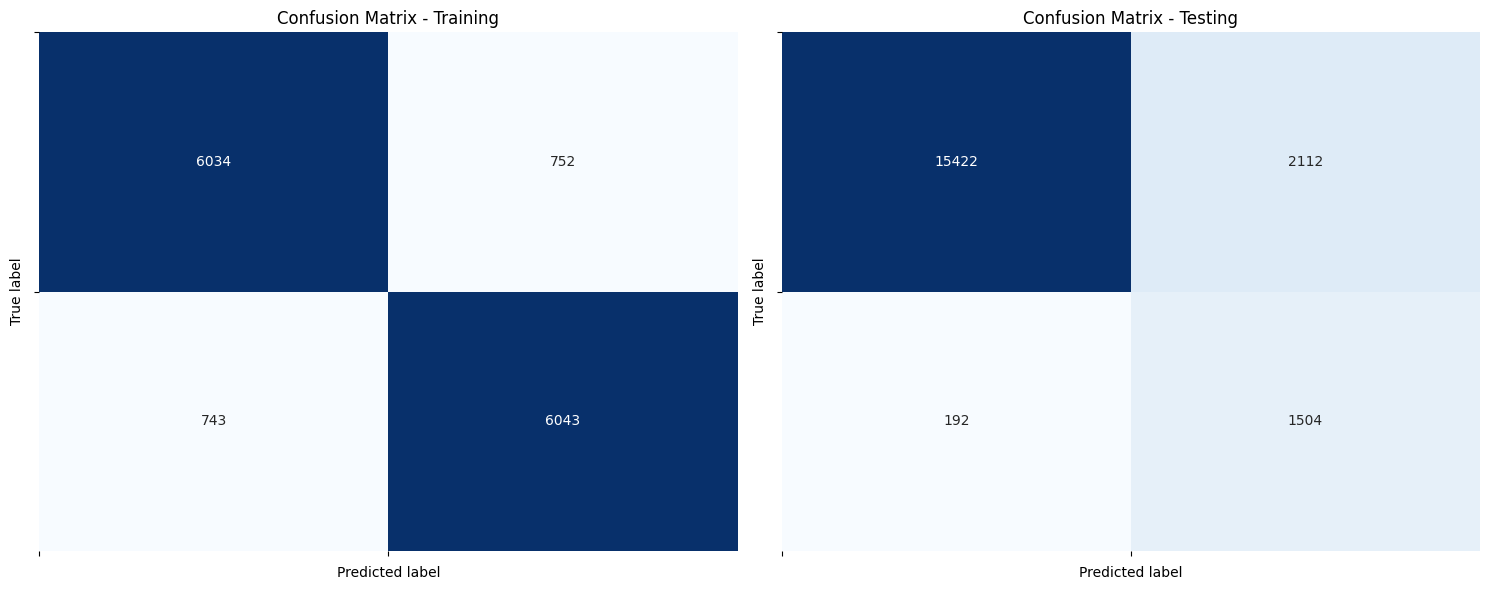

In [267]:
# Menampilkan confusion matrix untuk training dan testing
cm_train = confusion_matrix(y_train_resampled, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrices(cm_train, cm_test, classes=[0, 1], titles=['Training', 'Testing'])

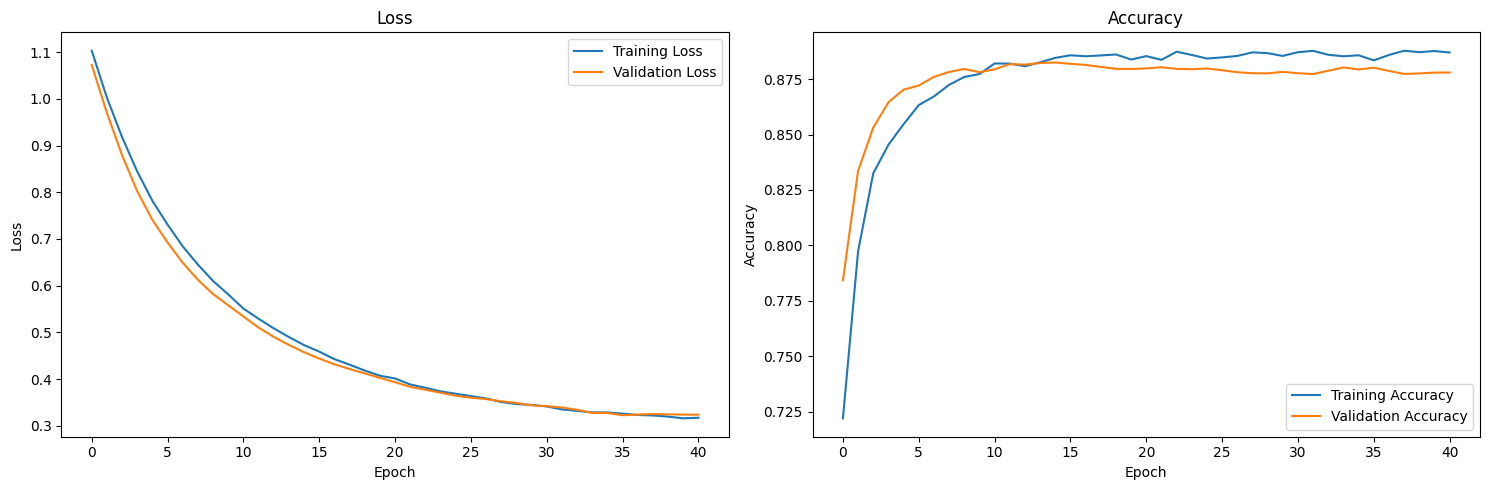

In [268]:
plot_loss_acc(history)

### <b>Save & Load Model</b>

In [269]:
model.save('diabetes.h5')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [270]:
from tensorflow.keras.models import load_model
import joblib

model = load_model('diabetes.h5')
scaler = joblib.load('scaler.pkl')

### <b>Prediksi data baru</b>

In [ ]:
import numpy as np

# Membuat data acak untuk fitur-fitur yang diperlukan
gender  = np.random.randint(0, 2)
age = np.random.randint(15, 60.)
hypertension = np.random.randint(0, 2)
heart_disease = np.random.randint(0, 2)
bmi = np.random.uniform(18.0, 30.0)
hbA1c_level = np.random.uniform(4.0, 7.0)
blood_glucose_level = np.random.randint(70, 200)

new_data = np.array([[gender, age, hypertension, heart_disease, bmi, hbA1c_level, blood_glucose_level]])

print("gender: ", new_data[0][0])
print("age: ", new_data[0][1])
print("hypertension: ", new_data[0][2])
print("heart_disease: ", new_data[0][3])
print("bmi: ", new_data[0][4])
print("HbA1c_level: ", new_data[0][5])
print("blood_glucose_level: ", new_data[0][6])

new_data_scaled = scaler.transform(new_data)
new_pred_prob = model.predict(new_data_scaled)

# Mengubah probabilitas menjadi prediksi biner (0 atau 1)
new_pred = np.where(new_pred_prob >= 0.5, 1, 0)

# Menampilkan hasil prediksi
if new_pred == 1:
    massage = 'Anda berpotensi diabetes!'
else:
    massage = 'Anda tidak berpotensi diabetes!'

if hbA1c_level > 6.0:
    hbA1c_suggestion_massage = 'Tingkat HbA1c Anda terbilang tinggi.'
else:
    hbA1c_suggestion_massage = 'Tingkat HbA1c Anda dalam batas normal, namun tetap penting untuk menjaga pola makan dan gaya hidup sehat.'

if blood_glucose_level > 140:
    blood_glucose_message = 'Tingkat gula darah Anda terbilang tinggi.'
else:
    blood_glucose_message = 'Tingkat gula darah Anda dalam batas normal, namun tetap penting untuk menjaga pola makan dan gaya hidup sehat.'


print(f'Probabilitas: {new_pred_prob[0][0]:.4f}')
print(f'Prediksi diabetes: {new_pred[0][0]}')
print(f'Prediksi diabetes: {massage}')
print('Saran:' + '\n' + f'{hbA1c_suggestion_massage}' + '\n' + f'{blood_glucose_message}')

gender:  0.0
age:  46.0
hypertension:  0.0
heart_disease:  1.0
bmi:  28.739882902179367
HbA1c_level:  6.697221915635607
blood_glucose_level:  127.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Probabilitas: 0.5906
Prediksi diabetes: 1
Prediksi diabetes: Anda berpotensi diabetes!
Saran:
Tingkat HbA1c Anda terbilang tinggi.
Tingkat gula darah Anda dalam batas normal, namun tetap penting untuk menjaga pola makan dan gaya hidup sehat.


d:\DiaCheck-ML\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
